In [1]:
library(png)
library(reticulate)
library(data.table)
library(plyr)
library(pryr)
library(ggplot2)
library(nloptr)
library(lme4)
library(lmerTest)
library(stringr)
library(bedr)
library(vcfR)


Attaching package: ‘pryr’


The following object is masked from ‘package:data.table’:

    address


Loading required package: Matrix


Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




######################
#### bedr v1.0.7 ####
######################

checking binary availability...
  * Checking path for bedtools... PASS
    /home/asalcedo/anaconda3/bin/bedtools
  * Checking path for bedops... FAIL
  * Checking path for tabix... PASS
    /home/asalcedo/anaconda3/bin/tabix
tests and examples will be skipped on R CMD check if binaries are missing



   *****       ***   vcfR   ***       *****
   This is vcfR 1.14.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****



Attaching package: ‘vcfR’


The following object is masked from ‘package:bedr’:

    write.vcf




In [2]:
manifest <- fread('/illumina/scratch/deep_learning/asalcedo/gdc_tcga_atac_jamboree_AWG_metadata.tsv')
sample_key <- fread("/illumina/scratch/deep_learning/asalcedo/scATAC/atac_tcga_key.txt")
atac_projects <- paste0('TCGA-', c('BLCA', 'BRCA','COAD','GBM', 'KIRC','KIRP','LUAD','SKCM'))

In [3]:
all_scores <- fread("/illumina/scratch/deep_learning/akumar22/TCGA/mutations_scoring/gwas_breast_control/breast_cancer_gwas_ld_expanded_scored.csv")

In [4]:
all_scores[,idx:=paste0(Chromosome,"_",hg38_end, "_", Reference_Allele, "_", Tumor_Seq_Allele2)]

In [5]:
all_scores[,tt:='BRCA']

In [6]:
all_vaf_df <- NULL
files <- list.files("/illumina/scratch/deep_learning/asalcedo/scATAC/BRCA_gwas_vafs/", pattern="expanded2.txt", full.names=TRUE)
for (file in files){
    vaf_df <- fread(file)
    case_id <- gsub("/.*/", "", file)
    case_id <- gsub("_wgs.*","", case_id)
    vaf_df$case_id <- case_id
    all_vaf_df <- rbind(all_vaf_df, vaf_df)    
}

In [13]:
head(all_vaf_df)

region,ref,alt,wgs_vaf,wgs_dp,atac_vaf,atac_dp,case_id
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
chr1:940263-940263,C,G,NA,NA,NA,NA,TCGA-A2-A0EY
chr1:941119-941119,A,G,NA,NA,NA,NA,TCGA-A2-A0EY
chr1:942335-942335,C,G,NA,NA,NA,NA,TCGA-A2-A0EY
chr1:943937-943937,C,T,0,24,0,7,TCGA-A2-A0EY
chr1:952180-952180,A,C,NA,NA,NA,NA,TCGA-A2-A0EY
chr1:957900-957900,G,A,NA,NA,NA,NA,TCGA-A2-A0EY


In [7]:
all_vaf_df[,vaf_difference:=atac_vaf-wgs_vaf]
all_vaf_df[,chrom:=gsub(":.*","",region)]
all_vaf_df[,pos:=gsub(".*-","",region)]
all_vaf_df[,idx:=paste0(chrom,"_",pos,"_",ref,"_",alt)]

In [16]:
head(all_vaf_df)

region,ref,alt,wgs_vaf,wgs_dp,atac_vaf,atac_dp,case_id,vaf_difference,chrom,pos,idx
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>
chr1:940263-940263,C,G,NA,NA,NA,NA,TCGA-A2-A0EY,NA,chr1,940263,chr1_940263_C_G
chr1:941119-941119,A,G,NA,NA,NA,NA,TCGA-A2-A0EY,NA,chr1,941119,chr1_941119_A_G
chr1:942335-942335,C,G,NA,NA,NA,NA,TCGA-A2-A0EY,NA,chr1,942335,chr1_942335_C_G
chr1:943937-943937,C,T,0,24,0,7,TCGA-A2-A0EY,0,chr1,943937,chr1_943937_C_T
chr1:952180-952180,A,C,NA,NA,NA,NA,TCGA-A2-A0EY,NA,chr1,952180,chr1_952180_A_C
chr1:957900-957900,G,A,NA,NA,NA,NA,TCGA-A2-A0EY,NA,chr1,957900,chr1_957900_G_A


In [9]:
nrow(all_vaf_df)
length(unique(all_vaf_df$case_id))

[1] 548300

[1] 10

In [11]:
head(all_scores)

Chromosome,hg38_start,hg38_end,Reference_Allele,Tumor_Seq_Allele2,mutation_id,rsid,peak_chr,peak_start,peak_end,⋯,proba_ref_summit_centered,proba_alt_summit_centered,diff_summit_centered,proba_ref_mutation_centered,proba_alt_mutation_centered,diff_mutation_centered,lof_summit_centered,gof_mutation_centered,idx,tt
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>
chr1,940262,940263,C,G,940263:C:G,rs7411115,chr1,940107,940607,⋯,0.9679392,0.9602326,0.0077065825,0.9881744,0.9839960,0.004178405,0,0,chr1_940263_C_G,BRCA
chr1,941118,941119,A,G,941119:A:G,rs4372192,chr1,940759,941259,⋯,0.9423096,0.9410040,0.0013055801,0.8032633,0.7799586,0.023304760,0,0,chr1_941119_A_G,BRCA
chr1,942334,942335,C,G,942335:C:G,rs6605066,chr1,942136,942636,⋯,0.9075794,0.9030668,0.0045126080,0.9308685,0.9232513,0.007617176,0,0,chr1_942335_C_G,BRCA
chr1,943936,943937,C,T,943937:C:T,rs7523549,chr1,943742,944242,⋯,0.7011319,0.7133506,-0.0122187140,0.5945183,0.6094178,-0.014899492,0,0,chr1_943937_C_T,BRCA
chr1,952179,952180,A,C,952180:A:C,rs3748595,chr1,951725,952225,⋯,0.5001137,0.5029615,-0.0028478503,0.8109176,0.8479017,-0.036984146,0,0,chr1_952180_A_C,BRCA
chr1,957899,957900,G,A,957900:G:A,rs4970371,chr1,957596,958096,⋯,0.9041237,0.9038093,0.0003144145,0.8898162,0.8866321,0.003184080,0,0,chr1_957900_G_A,BRCA


In [8]:
all_vafs_scored <- merge(all_vaf_df, all_scores[,.( diff_summit_centered, idx, lof_summit_centered)], by.x=c("idx"), by.y=c("idx"), all=TRUE)
all_vafs_scored <- unique(all_vafs_scored)

In [9]:
nrow(all_vafs_scored[!is.na(lof_summit_centered),])
length(unique(all_vafs_scored[!is.na(lof_summit_centered),]$case_id))
head(all_vafs_scored)

[1] 462100

[1] 10

idx,region,ref,alt,wgs_vaf,wgs_dp,atac_vaf,atac_dp,case_id,vaf_difference,chrom,pos,diff_summit_centered,lof_summit_centered
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<int>
chr10_101121409_C_T,chr10:101121409-101121409,C,T,0,24,0,2,TCGA-A2-A0EY,0,chr10,101121409,-0.01054764,0
chr10_101121409_C_T,chr10:101121409-101121409,C,T,0,3,0,12,TCGA-A2-A0YG,0,chr10,101121409,-0.01054764,0
chr10_101121409_C_T,chr10:101121409-101121409,C,T,0,2,0,7,TCGA-A7-A0D9,0,chr10,101121409,-0.01054764,0
chr10_101121409_C_T,chr10:101121409-101121409,C,T,0,34,0,6,TCGA-A8-A094,0,chr10,101121409,-0.01054764,0
chr10_101121409_C_T,chr10:101121409-101121409,C,T,0,36,0,14,TCGA-AO-A03L,0,chr10,101121409,-0.01054764,0
chr10_101121409_C_T,chr10:101121409-101121409,C,T,0,31,0,15,TCGA-AO-A03N,0,chr10,101121409,-0.01054764,0


In [22]:
nrow(all_vaf_df)

[1] 462100

In [24]:
nrow(all_vafs_scored)
nrow(all_vafs_scored[!is.na(diff_summit_centered)])

[1] 462100

[1] 462100

In [31]:
length(unique(all_vafs_scored$idx))
length(unique(filtered_vafs_scored$idx))

[1] 46210

[1] 2945

In [10]:
filtered_vafs_scored <- all_vafs_scored[(wgs_dp > 30) & (atac_dp > 30),][wgs_vaf > 0.4,]

In [21]:
table(filtered_vafs_scored[lof_summit_centered > 0,]$case_id)
table(filtered_vafs_scored$case_id)


TCGA-A2-A0EY TCGA-A2-A0YG TCGA-A8-A094 TCGA-AO-A03L TCGA-AO-A03N TCGA-AO-A0JM 
          18            2            7           18            6            4 
TCGA-BH-A0E0 TCGA-C8-A12Q TCGA-C8-A130 
           8           11            2 


TCGA-A2-A0EY TCGA-A2-A0YG TCGA-A7-A0D9 TCGA-A8-A094 TCGA-AO-A03L TCGA-AO-A03N 
         734          196           75          489          841          463 
TCGA-AO-A0JM TCGA-BH-A0E0 TCGA-C8-A12Q TCGA-C8-A130 
         252          294          578          171 

In [12]:
head(filtered_vafs_scored)

idx,region,ref,alt,wgs_vaf,wgs_dp,atac_vaf,atac_dp,case_id,vaf_difference,chrom,pos,diff_summit_centered,lof_summit_centered
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<int>
chr10_101454023_G_C,chr10:101454023-101454023,G,C,0.4081633,49,0.4848485,33,TCGA-AO-A0JM,0.07668522,chr10,101454023,-8.853555e-03,0
chr10_101817731_G_A,chr10:101817731-101817731,G,A,0.5897436,39,0.5400000,50,TCGA-C8-A12Q,-0.04974359,chr10,101817731,4.404187e-04,0
chr10_102198894_T_C,chr10:102198894-102198894,T,C,0.5166667,60,0.5703125,128,TCGA-BH-A0E0,0.05364583,chr10,102198894,8.583069e-05,0
chr10_110433715_G_C,chr10:110433715-110433715,G,C,0.9841270,63,0.9736842,38,TCGA-AO-A03L,-0.01044277,chr10,110433715,-1.316369e-03,0
chr10_110433979_C_G,chr10:110433979-110433979,C,G,0.4067797,59,0.1090909,55,TCGA-AO-A03N,-0.29768875,chr10,110433979,1.218911e-01,1
chr10_110434034_G_T,chr10:110434034-110434034,G,T,0.5294118,34,0.9729730,37,TCGA-A8-A094,0.44356121,chr10,110434034,2.604544e-03,0


In [13]:
out_df <- filtered_vafs_scored[,.(chrom, pos, ref, alt, idx, case_id, atac_dp, wgs_dp, atac_vaf, wgs_vaf, vaf_difference, diff_summit_centered, lof_summit_centered)]

In [14]:
head(out_df)

chrom,pos,ref,alt,idx,case_id,atac_dp,wgs_dp,atac_vaf,wgs_vaf,vaf_difference,diff_summit_centered,lof_summit_centered
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
chr10,101454023,G,C,chr10_101454023_G_C,TCGA-AO-A0JM,33,49,0.4848485,0.4081633,0.07668522,-8.853555e-03,0
chr10,101817731,G,A,chr10_101817731_G_A,TCGA-C8-A12Q,50,39,0.5400000,0.5897436,-0.04974359,4.404187e-04,0
chr10,102198894,T,C,chr10_102198894_T_C,TCGA-BH-A0E0,128,60,0.5703125,0.5166667,0.05364583,8.583069e-05,0
chr10,110433715,G,C,chr10_110433715_G_C,TCGA-AO-A03L,38,63,0.9736842,0.9841270,-0.01044277,-1.316369e-03,0
chr10,110433979,C,G,chr10_110433979_C_G,TCGA-AO-A03N,55,59,0.1090909,0.4067797,-0.29768875,1.218911e-01,1
chr10,110434034,G,T,chr10_110434034_G_T,TCGA-A8-A094,37,34,0.9729730,0.5294118,0.44356121,2.604544e-03,0


In [15]:
write.table(out_df,file="/illumina/scratch/deep_learning/asalcedo/scATAC/tables/gwas_ld_expanded_variants_with_scores.txt", quote=FALSE, row.names = FALSE, sep="\t")

In [25]:
filtered_vafs_scored[,.N,by=lof_summit_centered]

lof_summit_centered,N
<int>,<int>
0,4017
1,76


lof_summit_centered,N
<int>,<int>
0,4017
1,76


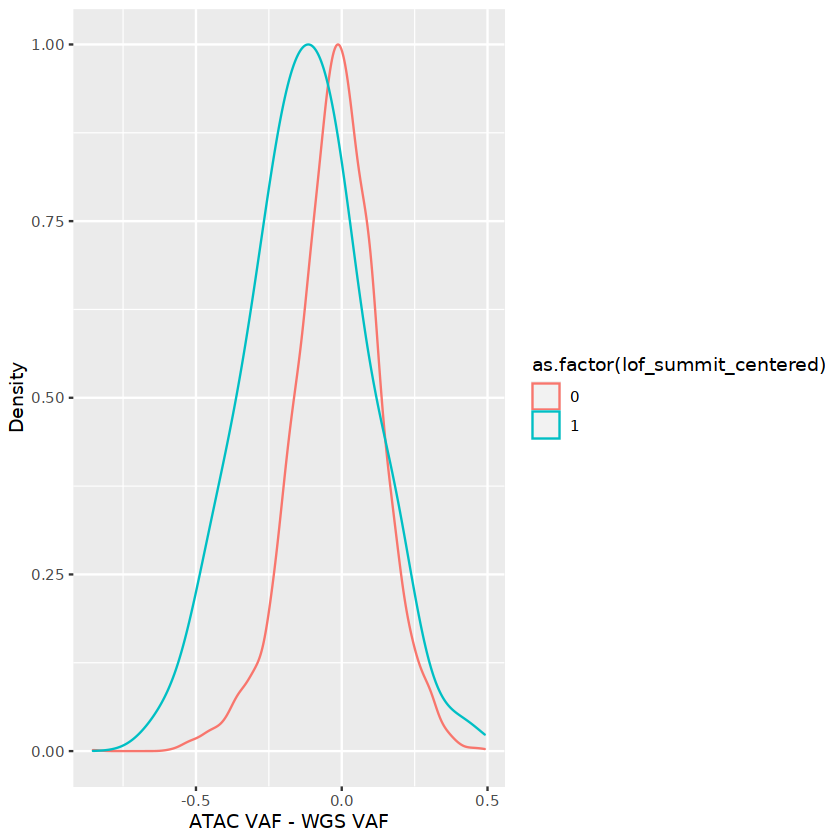

In [26]:
filtered_vafs_scored[,.N,by=lof_summit_centered]
ggplot(filtered_vafs_scored, aes(x=vaf_difference, color=as.factor(lof_summit_centered))) + geom_density(aes(y=..scaled..), alpha=.1) + xlab("ATAC VAF - WGS VAF") + ylab("Density")

In [27]:
test_df <- filtered_vafs_scored
t.test(test_df[lof_summit_centered == 1,]$vaf_difference, test_df[lof_summit_centered == 0,]$vaf_difference)
wilcox.test(test_df[lof_summit_centered == 1,]$vaf_difference, test_df[lof_summit_centered == 0,]$vaf_difference)


	Welch Two Sample t-test

data:  test_df[lof_summit_centered == 1, ]$vaf_difference and test_df[lof_summit_centered == 0, ]$vaf_difference
t = -4.4304, df = 76.498, p-value = 3.092e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1489533 -0.0565699
sample estimates:
  mean of x   mean of y 
-0.12135955 -0.01859796 



	Wilcoxon rank sum test with continuity correction

data:  test_df[lof_summit_centered == 1, ]$vaf_difference and test_df[lof_summit_centered == 0, ]$vaf_difference
W = 101968, p-value = 6.848e-07
alternative hypothesis: true location shift is not equal to 0
